In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
# from topoPy import *

In [2]:
def readnc(datfile,var):
    #---- topography data file
    df = nc.Dataset(datfile)
    # print(df.variables)
    
    #---- variable and coordinates
    lon, lat = df.variables['lon'][:], df.variables['lat'][:]
    z = df.variables[var['name']][:]
    df.close()
    
    return lon, lat, z

def fetch_vwdata_by_idx(datfile,var,lon_centre,lat_centre,lon_vert,lat_vert,links):
    
    #---- variable and the coordinates
    lon, lat, z = readnc(datfile, var)
    
    #---- get number of records,nlat,nlon
    nrecords = np.shape(z)[0]; nlon = np.shape(lon)[1]; nlat = np.shape(lat)[1]
    
    #---- process each record to get the (lon,lat) for each topographic observation in 1D
    lon_res=[]; lat_res=[]; z_res=[]   # resulting lon,lat,z  
    
    for n in links:
        # print('n = ',n)
        lon_,lat_ = np.meshgrid(lon[n][:],lat[n][:])
#         print(lon_, lat_)
        lon_= lon_.ravel() 
        lat_ = lat_.ravel() 
        z_ = np.flipud(z[n][:])
        
        # print(z_[5])
        z_ = z_.ravel()
#         print(lon_.shape, lat_.shape, z_.shape)
        cond_lat = ( lat_vert.min() <= lat_ ) & ( lat_ <= lat_vert.max() )
        cond_lon = ( lon_vert.min() <= lon_ ) & ( lon_ <= lon_vert.max() )
        idx = np.nonzero((cond_lat & cond_lon))[0]

        # idx = np.nonzero((np.abs(lon_ - lon_centre)<= lon_width/2) & 
                         # (np.abs(lat_ - lat_centre)<= lat_width/2))[0]
        # print(idx)
        if len(idx)!=0:
            lon_dummy,lat_dummy,z_dummy = lon_[idx],lat_[idx],z_[idx]
            lon_res.extend(lon_dummy.tolist())
            lat_res.extend(lat_dummy.tolist())
            z_res.extend(z_dummy.tolist())
    
    lon_res = np.array(lon_res)
    lat_res = np.array(lat_res)
    z_res = np.array(z_res)
        
    # print(z_res[300:350])
    
    del lat, lon, z
        
    #---- processing of the lat,lon,topo to get the regular 2D grid for topography
    lon_uniq, lat_uniq = np.unique(lon_res), np.unique(lat_res) # get unique values of lon,lat
    nla = len(lat_uniq); nlo = len(lon_uniq)
    
    # print("lat_res shape = ", lat_res.shape)
    # print("lon_res shape = ", lon_res.shape)
    # print("z_res shape = ", z_res.shape)
    # print("nla = ", nla)
    # print("nlo = ", nlo)

    #---- building 2D topography field
    lat_lon_topo = np.vstack((lat_res,lon_res,z_res)).T
    lat_lon_topo = lat_lon_topo[lat_lon_topo[:,0].argsort()]  # sorted according to latitude
    lon_sort_id = [lat_lon_topo[n*nlo:(n+1)*nlo,1].argsort()+nlo*n for n in range(nla)] 
    lon_sort_id = np.array(lon_sort_id).reshape(-1)
    lat_lon_topo = lat_lon_topo[lon_sort_id]  # sorted according to longitude for each len(lon_u)
    topo_2D = np.reshape(lat_lon_topo[:,2],(nla,nlo))
    
    del lat_lon_topo, lon_sort_id
        
    # print('Data fetched...')
    return lon_uniq, lat_uniq, topo_2D

In [20]:
sfx = '28deg'

df = nc.Dataset('../data/icon_compact_linked_%s.nc' %sfx)

clat = df.variables['clat'][:]
clon = df.variables['clon'][:]
clat_vertices = df.variables['clat_vertices'][:]
clon_vertices = df.variables['clon_vertices'][:]
links = df.variables['links'][:]

df.close()

# print(links)

clat = clat*(180/np.pi)
clon = clon*(180/np.pi)

clat_vertices = clat_vertices*(180/np.pi)
clon_vertices = clon_vertices*(180/np.pi)

datfile = '../data/topo_compact_%s.nc' %sfx
var = {'name':'topo','units':'m'}

# lon, lat, z = readnc(datfile, var)
# nrecords = np.shape(z)[0]; nlon = np.shape(lon)[1]; nlat = np.shape(lat)[1]

df_out = nc.Dataset('../data/output_%s.nc' %sfx)

nouts = clat.shape[0]
# nouts = 90

for vid in range(0,nouts):
    lat_centre = clat[vid]
    lon_centre = clon[vid]
    lat_vert = clat_vertices[vid,:]
    lon_vert = clon_vertices[vid,:]
    
    nonzero_links = links[vid,:]
    nonzero_links = nonzero_links[nonzero_links > 0]

#     # ---- get the topography around the cell picked

    %time lon,lat,z = fetch_vwdata_by_idx(datfile,var,lon_centre,lat_centre,lon_vert,lat_vert,nonzero_links-1)
    
    # print(z[0][300:350])
    
    i = vid+1
    name = "topo_%i" %i
    lat_name = "lat_grid_%i" %i
    lon_name = "lon_grid_%i" %i
    
    data = df_out.variables[name][:]
    lat_grid = df_out.variables[lat_name][:]
    lon_grid = df_out.variables[lon_name][:]
    
    # print(data)

    # print(lat-lat_grid[:,0])
    # print(lon-lon_grid[0,:])
    
    # plt.contourf(lon,lat,z,60)
    # x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
    # y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
    # plt.plot(x,y,'-r')
    # plt.colorbar()
    # plt.show()

CPU times: user 211 ms, sys: 327 ms, total: 538 ms
Wall time: 539 ms
CPU times: user 200 ms, sys: 293 ms, total: 493 ms
Wall time: 494 ms
CPU times: user 179 ms, sys: 299 ms, total: 478 ms
Wall time: 479 ms
CPU times: user 190 ms, sys: 280 ms, total: 470 ms
Wall time: 471 ms
CPU times: user 344 ms, sys: 342 ms, total: 686 ms
Wall time: 688 ms
CPU times: user 307 ms, sys: 328 ms, total: 635 ms
Wall time: 635 ms
CPU times: user 176 ms, sys: 314 ms, total: 490 ms
Wall time: 491 ms
CPU times: user 202 ms, sys: 285 ms, total: 488 ms
Wall time: 488 ms


KeyboardInterrupt: 

CPU times: user 176 ms, sys: 306 ms, total: 483 ms
Wall time: 484 ms
CPU times: user 207 ms, sys: 277 ms, total: 485 ms
Wall time: 485 ms
CPU times: user 180 ms, sys: 313 ms, total: 492 ms
Wall time: 493 ms
CPU times: user 323 ms, sys: 333 ms, total: 655 ms
Wall time: 656 ms
CPU times: user 220 ms, sys: 274 ms, total: 494 ms
Wall time: 494 ms
CPU times: user 341 ms, sys: 351 ms, total: 692 ms
Wall time: 693 ms
CPU times: user 297 ms, sys: 351 ms, total: 648 ms
Wall time: 649 ms
CPU times: user 213 ms, sys: 286 ms, total: 499 ms
Wall time: 499 ms
CPU times: user 355 ms, sys: 329 ms, total: 684 ms
Wall time: 686 ms
CPU times: user 213 ms, sys: 312 ms, total: 525 ms
Wall time: 526 ms
CPU times: user 173 ms, sys: 298 ms, total: 471 ms
Wall time: 471 ms
CPU times: user 195 ms, sys: 284 ms, total: 479 ms
Wall time: 479 ms
CPU times: user 187 ms, sys: 287 ms, total: 474 ms
Wall time: 474 ms
CPU times: user 313 ms, sys: 369 ms, total: 682 ms
Wall time: 683 ms
CPU times: user 197 ms, sys: 296 m

(252, 274)


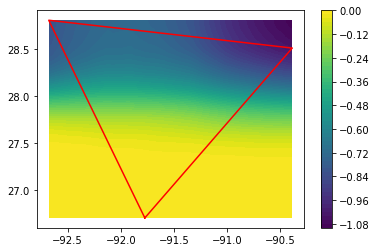

(249, 277)


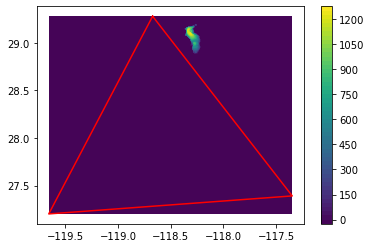

In [17]:
sfx = '28deg'
df = nc.Dataset('../data/output_%s.nc' %sfx)

# for i in range(1,nouts+1):
for i in [23,25]:
    name = "topo_%i" %i
    lat_name = "lat_grid_%i" %i
    lon_name = "lon_grid_%i" %i
    
    data = df.variables[name][:]
    lat_grid = df.variables[lat_name][:]
    lon_grid = df.variables[lon_name][:]
    
    lon_grid[np.where(lon_grid > 180.0)] -= 360.0
    
    print(data.shape)

    plt.contourf(lon_grid, lat_grid, data, 60)
    
    vid = i-1
    x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
    y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
    plt.plot(x,y,'-r')
    plt.colorbar()
    plt.show()

df.close()

In [21]:
def rad_to_deg(val):
    return val * 180.0 / np.pi

vx = np.array([-2.8907089284406324, 0.6283185307179578, 1.8849555921538772])
vx = np.array([0.24288209097473423, 8.655095639727097E-15, 1.256637061435913])

vx = rad_to_deg(vx)

vy = np.array([1.5707963267948946, 1.5396079515651673, 1.5396079515651668])
# vy = np.array([1.5707963267948948	1.5396079515651657	1.5396079515651668]
vy = rad_to_deg(vy)
print(vy)
print(vx)


def tri_area(x,y):
    Ax,Bx,Cx = vx[0], vx[1], vx[2]
    Ay,By,Cy = vy[0], vy[1], vy[2]
    
    return Ax * (By - Cy) + Bx * (Cy - Ay) + Cx * (Ay - By)

print(tri_area(vx,vy))

[90.         88.21303773 88.21303773]
[1.39161187e+01 4.95900451e-13 7.20000000e+01]
128.66128347842903


10 0.0 196.98434257507324


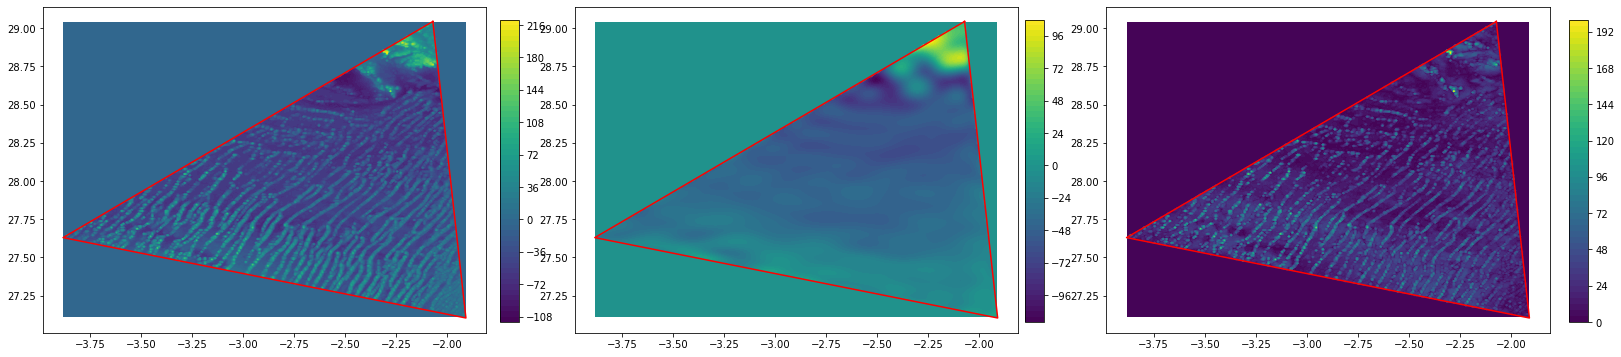


11 0.0 876.9843444824219


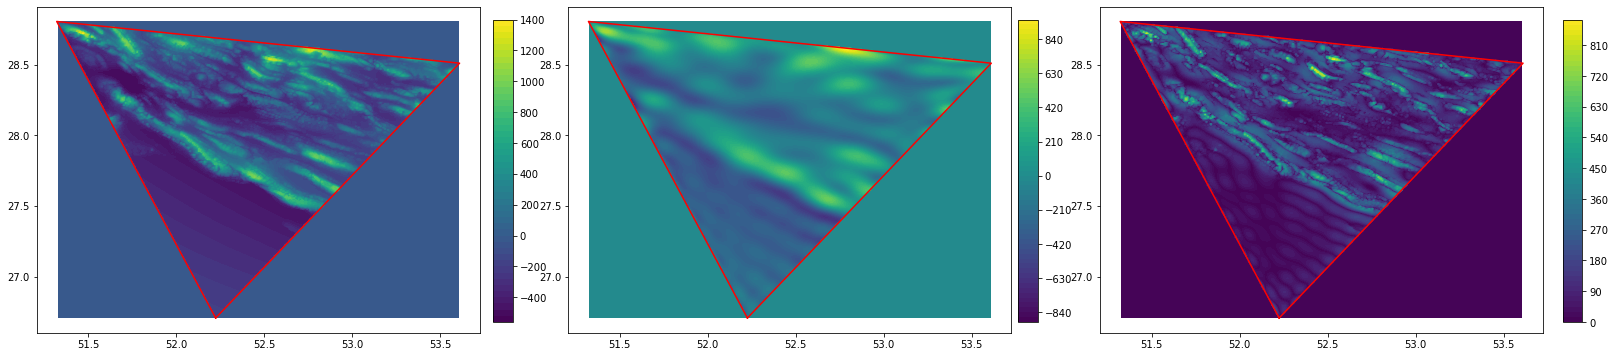


12 0.0 43.57072639465332


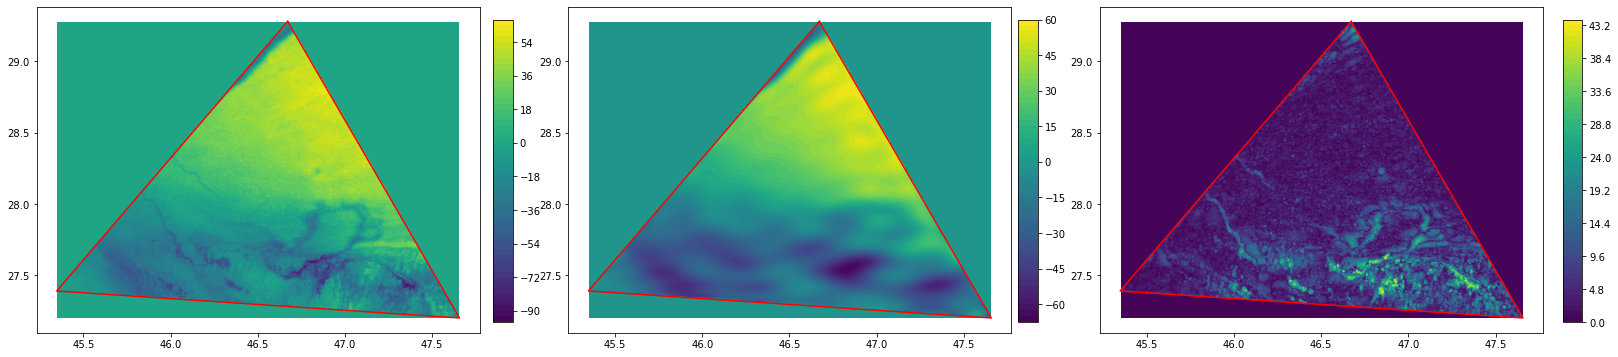


13 0.0 81.32486724853516


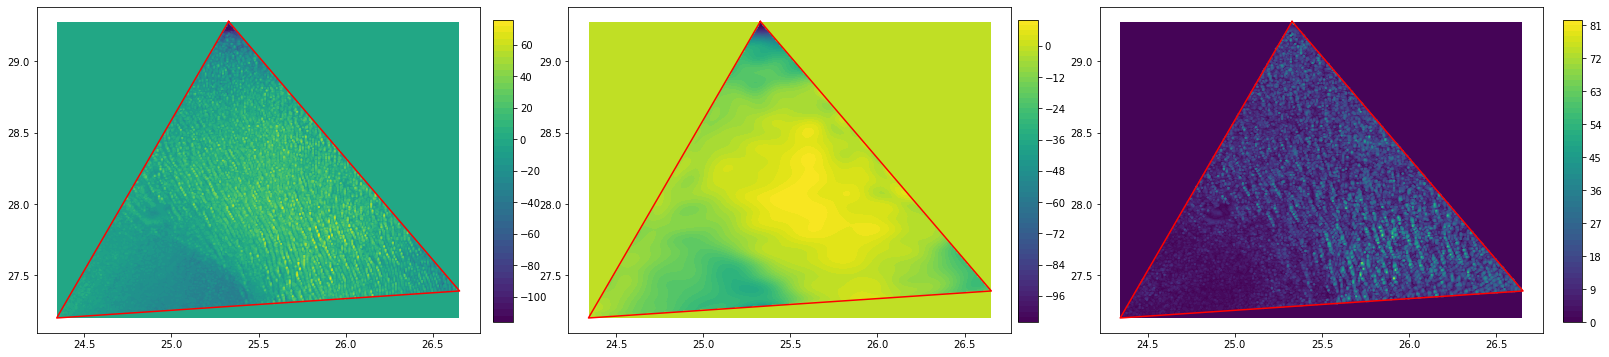


14 0.0 144.45834732055664


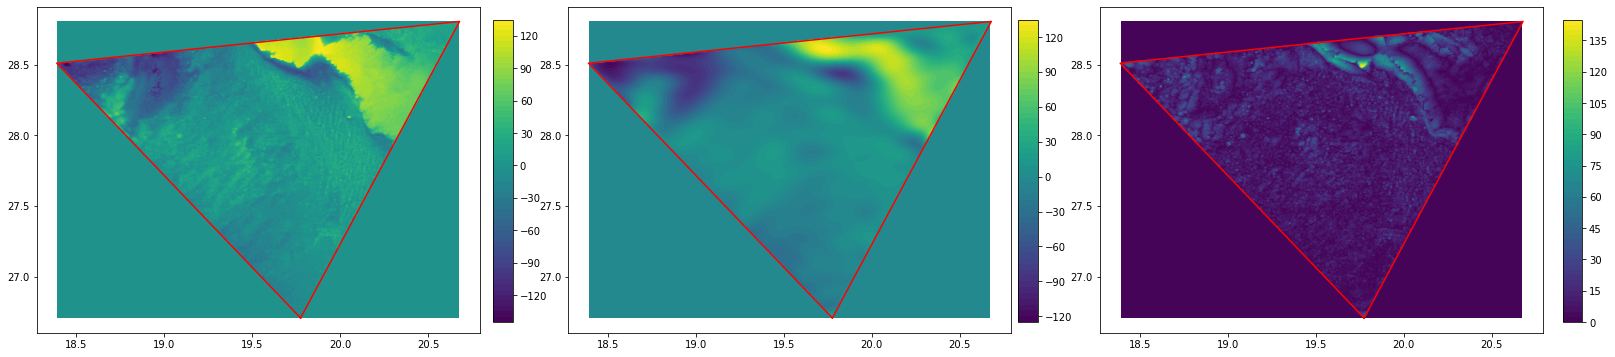


15 0.0 6.683224678039551


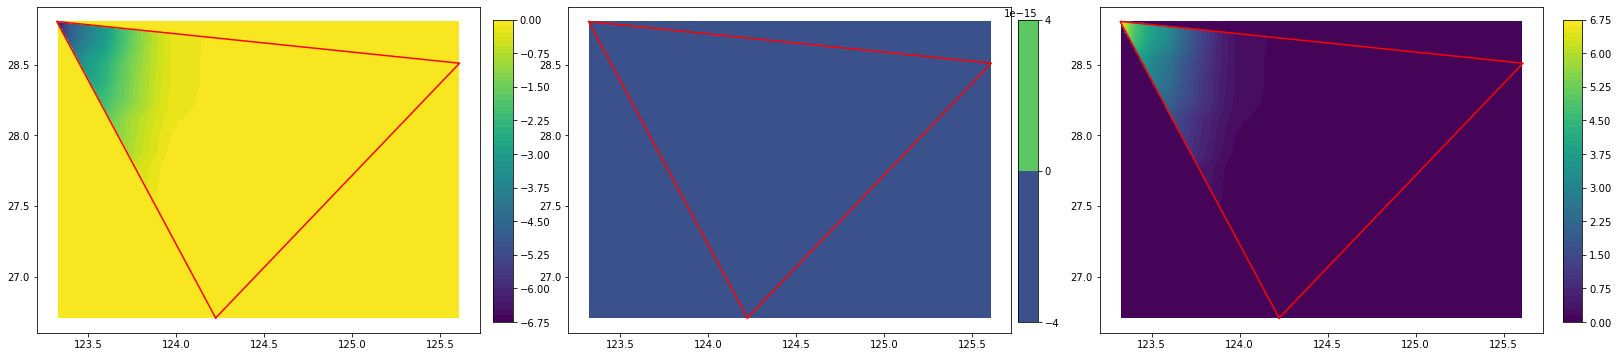

In [224]:
sfx = '28deg'
sfx = '28deg_full_hhat_div_ncnd'
sfx = '28deg'
df = nc.Dataset('../data/output_%s.nc' %sfx)

for i in range(10,16):
    name = "topo_%i" %i
    lat_name = "lat_grid_%i" %i
    lon_name = "lon_grid_%i" %i
    recon_name = "topo_recon_%i" %i
    mask_name = "mask_%i" %i
    
    data = df.variables[name][:]
    lat_grid = df.variables[lat_name][:]
    lon_grid = df.variables[lon_name][:]
    topo_grid = df.variables[recon_name][:]
    mask = df.variables[mask_name][:]
    
    lon_grid[np.where(lon_grid > 180.0)] -= 360.0
    
#     print(i, data_masked.min(), data_masked.max())
#     print(i, topo_grid.min(), topo_grid.max())
    
    data_masked = data*mask
    # fig = plt.figure()
    # gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.1)
    # (ax1, ax2) = gs.subplots()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27, 6))
    im1 = ax1.contourf(lon_grid, lat_grid, data_masked, 60)
    vid = i-1
    x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
    y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
    ax1.plot(x,y,'-r')
    
    cbar_ax = fig.add_axes([0.36, 0.15, 0.01, 0.7])
    fig.colorbar(im1, cax=cbar_ax)
    
    im2 = ax2.contourf(lon_grid, lat_grid, topo_grid, 60)
    ax2.plot(x,y,'-r')
    # cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    # fig.colorbar(im2, cax=cbar_ax)
    
    diff_topo = np.abs(data_masked-topo_grid)
    print(i, diff_topo.min(), diff_topo.max())
    im3 = ax3.contourf(lon_grid, lat_grid, diff_topo, 60)
    ax3.plot(x,y,'-r')
    
    cbar_ax = fig.add_axes([0.63, 0.15, 0.01, 0.7])
    fig.colorbar(im2, cax=cbar_ax)
    
    cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    fig.colorbar(im3, cax=cbar_ax)
    plt.show()
    
    print("")

df.close()

28deg
71292235.26629329 681699332.924768


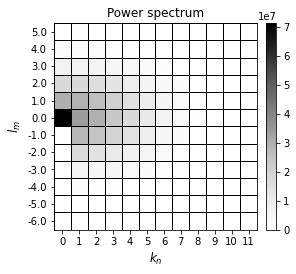

160403383.68857387 1385722621.1734684


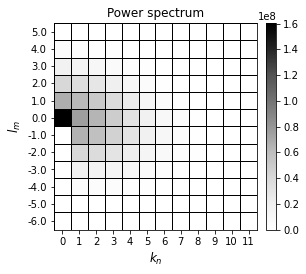

34421610.21220088 289018752.784812


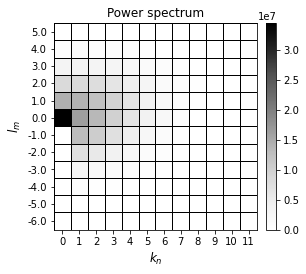

0.0 0.0


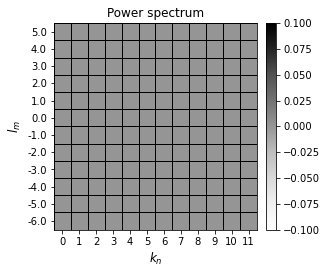

0.0 0.0


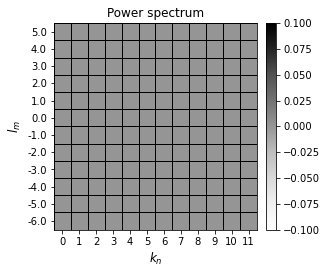

0.0 0.0


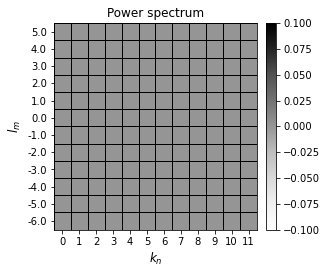

0.0 0.0


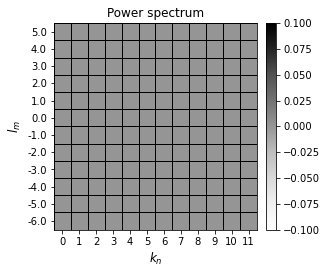

0.0 0.0


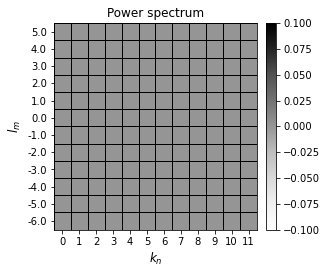

0.0 0.0


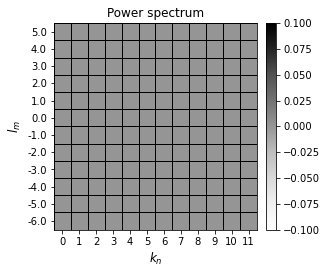

107638753.22255622 926345092.6304791


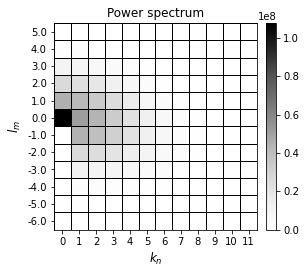

3656860979.3714905 35700451817.25664


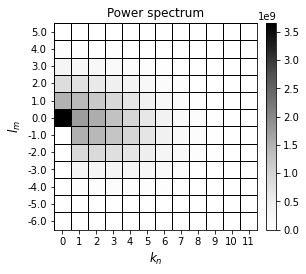

8965163.46169345 104640578.0719766


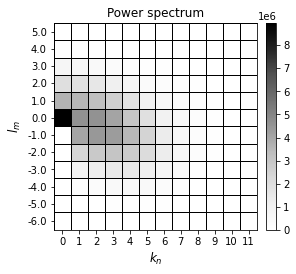

19407686.675119102 190112951.90729666


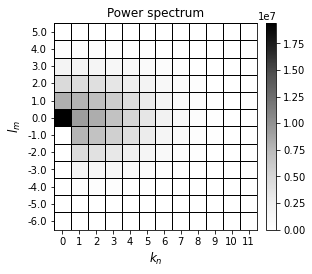

9567107.882162094 93084454.9476035


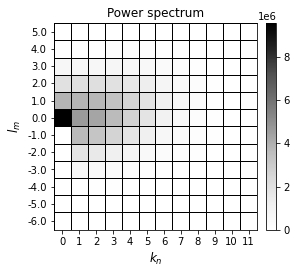

0.0 0.0


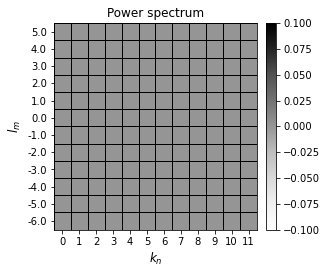

334694052.4023255 3749203352.5315356


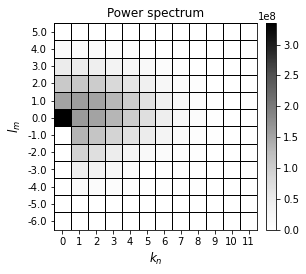

129464020.767993 3222750015.2353354


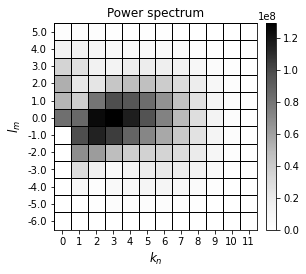

3781355266.6514397 37320085585.98113


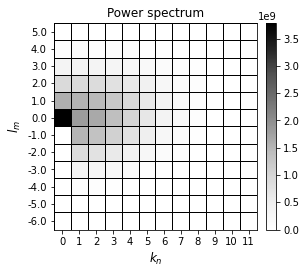

0.0 0.0


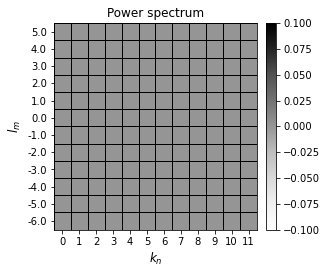

0.0 0.0


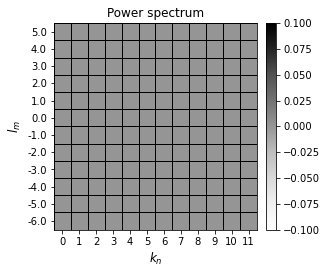

0.0 0.0


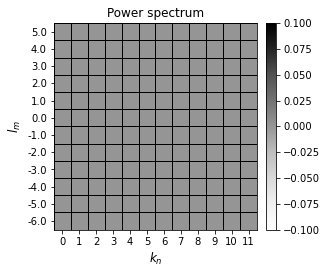

0.0 0.0


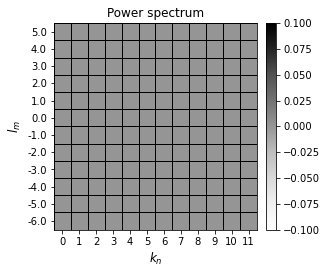

0.0 0.0


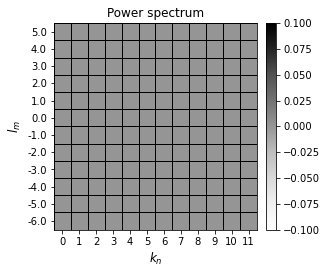

31428700.74579195 331637890.0162238


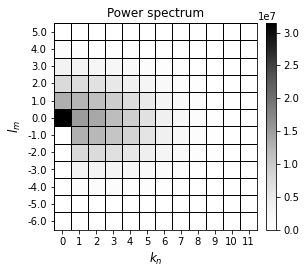

1692.0576387846377 29656.42065582357


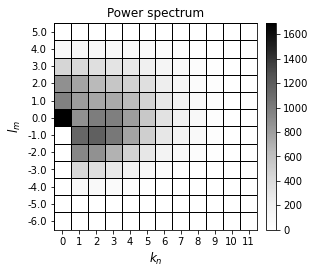

0.0 0.0


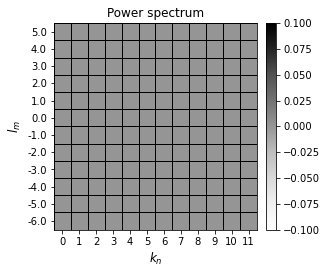

0.0 0.0


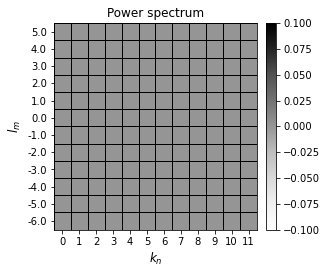

0.0 0.0


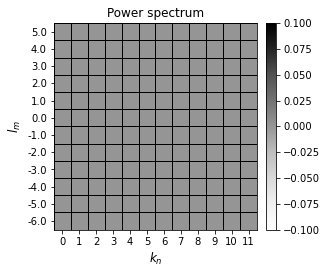

0.0 0.0


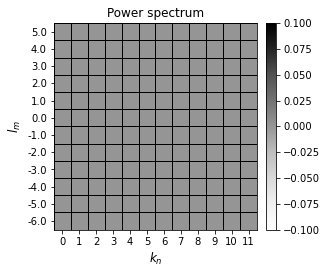

0.0 0.0


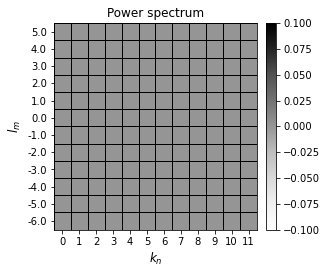

In [238]:
sfx = '28deg_full_x2_x144'
sfx = '28deg_full_norm'
# sfx = '28deg_axial_norm'

sfx = '28deg_full'
sfx = '28deg_axial'
sfx = '28deg'

print(sfx)

df = nc.Dataset('../data/output_%s.nc' %sfx)

re_name = "re_fcoeffs"
im_name = "im_fcoeffs"

real = df.variables[re_name][:]
imag = df.variables[im_name][:]

wlat = df.variables['wavelength_lat'][:]
wlon = df.variables['wavelength_lon'][:]

for i in range(0,nouts):

    idx = i
    
    fcoeffs = real[idx] + 1.0j * imag[idx]
    
    fs = (4,3.8)
    plt.figure(figsize=fs)
    
    arr = np.real(fcoeffs * np.conj(fcoeffs))**0.5
    arr = np.abs(fcoeffs)#**0.5
    print(arr.max(), arr.sum())

    im = plt.pcolormesh(arr, edgecolors='k', cmap='Greys')
    plt.colorbar(im,fraction=0.05, pad=0.04)
    nhar_j = 12
    if nhar_j % 2 == 0:
        m_j = np.arange(-nhar_j/2,nhar_j/2)
    else:
        m_j = np.arange(-(nhar_j-1)/2,(nhar_j)/2)

    ylocs = np.arange(.5,12.5,1.0)
    plt.yticks(ylocs, m_j)
    plt.xticks(ylocs, np.arange(0,12))
    plt.title("Power spectrum")
    plt.xlabel(r'$k_n$', fontsize=12)
    plt.ylabel(r'$l_m$', fontsize=12)
    # plt.grid()
    # plt.savefig('axial_coeffs_rot.pdf', bbox_inches='tight')
    plt.show()

df.close()

In [232]:
def get_Ag(fn):
    df = nc.Dataset(fn)

    re_name = "re_fcoeffs"
    im_name = "im_fcoeffs"

    real = df.variables[re_name][:].transpose(0,2,1)
    imag = df.variables[im_name][:].transpose(0,2,1)

    wlat = df.variables['wavelength_lat'][:]
    wlon = df.variables['wavelength_lon'][:]
    # wlat = 0.00833
    # wlon = 0.00833

    df.close()
    
    ncells = real.shape[0]

    AE = 6371.0008 * 1E3 # Earth's radius in [m]

    wla = wlat * AE
    wlo = wlon * AE

    hhg = real + 1.0j * imag

    # print(hhg[0:10])

    N = 0.02 # s^{-1}
    U = 10.0 # m s^{-1}
    V = 10.0 # m s^{-1}

    kk = np.arange(0,12)
    ll = np.arange(-6,6)

    # print(kk, ll)
    kkg, llg = np.meshgrid(kk,ll)
    
    # print(kkg.shape, llg.shape)

    kkg = np.expand_dims(kkg,0)
    llg = np.expand_dims(llg,0)
    wla = np.expand_dims(wla,1)
    wlo = np.expand_dims(wlo,1)
    wla = np.expand_dims(wla,1)
    wlo = np.expand_dims(wlo,1)
    
    # print(kkg.shape, llg.shape)
    # print(wla.shape, wlo.shape)

    # kkg = np.dot(1.0 / wlo, kkg)
    kkg = np.repeat(kkg, ncells, axis=0) / wlo
    llg = np.repeat(llg, ncells, axis=0) / wla

    # print(kkg.shape, llg.shape)
    # print(kkg**2 + llg**2)

    omg_grid_sq = (- kkg * U - llg * V)**2
    # print(omg_grid_sq)
    mmg = np.sqrt((N**2 * (kkg**2 + llg**2) / omg_grid_sq) - (kkg**2 + llg**2))

    h2 = hhg * np.conj(hhg)
    # if 'full' in fn:
    #     h2 /= (275**2)
    Ag = 0.5 * ( h2 * N**2 / np.sqrt(omg_grid_sq) ) #* 1e-12
    cgz = N * kkg * mmg / (kkg**2 + mmg**2)**(3/2)
    
    Ag = np.real(Ag) * kkg * cgz
    Ag = Ag.sum(axis=(1,2))
    # Ag[np.where(Ag==np.nan)] = 0.0
    Ag = Ag.filled(np.nan)
    # Ag[np.ma.masked_invalid(Ag)] = np.nan
    # print(Ag.shape)

    
    # print(mmg)

    # print(Ag[100:200])
    return Ag

fn1 = '../data/output_28deg_full_norm_test.nc'
Ag1 = get_Ag(fn1)

fn2 = '../data/output_28deg_axial_norm_test.nc'
Ag2 = get_Ag(fn2)

In [233]:
print(Ag1)
print(Ag2)

[1.06326649e+13 1.17493142e+13 3.23026015e+12 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.01947774e+13 1.94601144e+14 4.46953771e+11
 1.57909986e+12 1.51172351e+11 0.00000000e+00 2.03312288e+15
 4.17520738e+14 7.12262321e+16 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03989168e+12
 2.89876725e+04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[2.68584038e+05 4.43919110e+05 1.20341487e+05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.35991735e+04 1.26308611e+06 4.41026815e+04
 3.25615989e+03 1.46778528e+04 0.00000000e+00 1.84510568e+06
 2.62383057e+07 3.27535374e+07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.86722469e+04
 2.07501754e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [38]:
AE = 6371.0008 * 1E3 # Earth's radius in [m]

re = real[0]
im = imag[0]
wla = wlat[0] * AE
wlo = wlon[0] * AE

hhg = re + 1.0j * im

# print(hhg)

N = 0.02 # s^{-1}
U = 10.0 # m s^{-1}
V = 10.0 # m s^{-1}

kk = np.arange(0,12) / wlo
ll = np.arange(-6,6) / wla

# print(kk, ll)
kkg, llg = np.meshgrid(kk,ll)

# print(kkg**2 + llg**2)

omg_grid_sq = (- kkg * U - llg * V)**2
# print(omg_grid_sq)

Ag = 0.5 * ( hhg * np.conj(hhg) * N**2 / np.sqrt(omg_grid_sq) ) * 1e-12
Ag = np.real(Ag)
print(Ag)
Agrid = Ag.sum()
print(Agrid)

mmg = np.sqrt((N**2 * (kkg**2 + llg**2) / omg_grid_sq) - (kkg**2 + llg**2))
# print(mmg)

[[0.0 0.10115344324022327 1.046455763443538 3.9798060568555904
  8.827065428427094 11.741036801253781 31093.88366361142
  0.1910103293041957 0.4116953245188307 0.24571250552902638
  0.0323549629085268 0.002864642702923833]
 [0.0 515.0017360562051 704.2925782864372 977.6948732073779
  1603.6653048088465 12391393.733182784 207.49860586619226
  2.248718614318532 4.490335101932788 3.6703374450779274
  0.5943546172120714 0.028095742455912454]
 [0.0 38027.37377926205 59048.98787201605 104199.88564349612
  1295818310.6691003 37160.179523870574 5152.00592840949
  320.5301306489125 0.7917710918061864 12.662206942906293
  3.135220245503115 0.10801702901473885]
 [0.0 699015.4311678909 1512828.0593509472 32727979217.24751
  1044074.0561123005 280206.8080513368 62529.393706120136
  7919.056062915757 354.8596183767852 0.3151325735097429
  4.161263404595475 0.2834454494486926]
 [0.0 6308744.423812694 251333500344.58026 7072640.782395132
  2805284.935377533 1089767.7385335346 314966.9242948737
  56307

/tmp/ipykernel_2745/1891504834.py:33: RuntimeWarning: invalid value encountered in true_divide
  mmg = np.sqrt((N**2 * (kkg**2 + llg**2) / omg_grid_sq) - (kkg**2 + llg**2))


0.4886921905584123


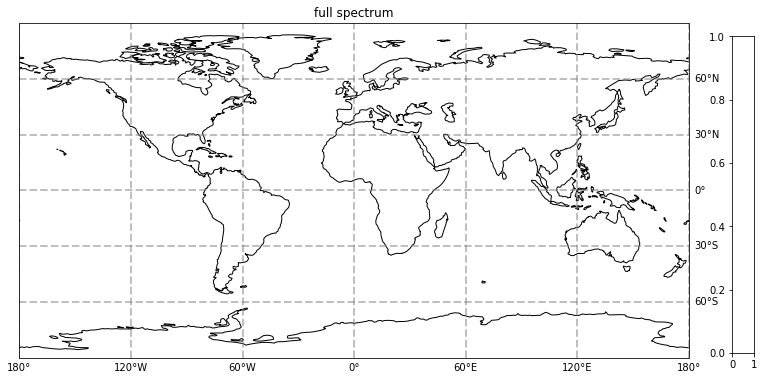